# Multivariate to each input/output Time Series

In [1]:
import numpy as np
import time
import math
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error

import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters
# https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/
# https://www.gritfeat.com/explainable-aixai-from-correlation-to-causation-shap-for-lstm-time-series-model/
#http://localhost:8888/lab/tree/MyQuantFinProject/TimeSeriesML-FinMarket/Nachiketa-Hebbar-LSTM/RNN_Youtube.ipynb

In [2]:
ab_path = "../data/SET50-Daily-Y09-Now.csv"
stockname='SET50'
start_date='2014-01-01'
end_date='2022-12-31'

# EMA2 and Signal

my_features=['Price', 'EMA1','EMA2','EMA3','MACD', 'SIGNAL', 'RSI','RSI-MA']
#my_features=['Price', 'EMA1','EMA2','MACD', 'SIGNAL', 'RSI','RSI-MA']
# each feature predict itself

n_early=10

train_ratio=0.8


n_batch=32
n_epochs=100


main_obj_metric='mean_absolute_error'
main_loss='mean_absolute_error'


# 60 predict 1
n_input =60
# define generator

n_features = len(my_features)
print(f"input={n_input} and features={n_features}")

model_path='models'

tune_folder='oneInput_oneOut_SET50'


seed=7


input=60 and features=8


# Load Data

In [3]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':'Date'},inplace=True)
allCols=list(df.columns)
print(allCols)

df['Date']=df['Date'].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index('Date',inplace=True)
df=df.loc[start_date:end_date][my_features]
print(df.info())
print(df.tail(3))



['Ticker', 'Date', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2190 entries, 2014-01-02 to 2022-12-30
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2190 non-null   float64
 1   EMA1    2190 non-null   float64
 2   EMA2    2190 non-null   float64
 3   EMA3    2190 non-null   float64
 4   MACD    2190 non-null   float64
 5   SIGNAL  2190 non-null   float64
 6   RSI     2190 non-null   float64
 7   RSI-MA  2190 non-null   float64
dtypes: float64(8)
memory usage: 154.0 KB
None
              Price    EMA1    EMA2    EMA3  MACD  SIGNAL    RSI  RSI-MA
Date                                                                    
2022-12-28  1000.54  985.80  983.87  983.87  1.92   -0.09  65.03   54.98
2022-12-29  1010.19  990.23  986.38  986.38  3.85    0.41  69.99   59.54
2022-12-30  1005.24  992.96  988.17  988.17  4.79    0.95  64.93   63.01


# Tranform Data

In [4]:
print("Tranform Data")
dfValues=df.values
print(dfValues.shape)
train_data_len = math.ceil(len(dfValues) * train_ratio)
print(f"{train_ratio} of {len(dfValues)} = The number of train data is {train_data_len}")
train_values = dfValues[0:train_data_len]
test_values = dfValues[train_data_len:]
print(train_values.shape,test_values.shape)
    
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
scaler = MinMaxScaler()
#scaler= PowerTransformer()
scaler.fit(train_values)
train = scaler.transform(train_values)
test = scaler.transform(test_values)

print(train.shape,test.shape)
print(type(train),type(test))
print(train[-2:])
print(test[-2:])

Tranform Data
(2190, 8)
0.8 of 2190 = The number of train data is 1752
(1752, 8) (438, 8)
(1752, 8) (438, 8)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[0.52877014 0.46467302 0.41298958 0.41298958 0.72331781 0.68618541
  0.55880372 0.50513196]
 [0.5284471  0.47010625 0.41686527 0.41686527 0.73203845 0.69280706
  0.55772599 0.53123167]]
[[0.62731833 0.56479352 0.52146073 0.52146073 0.72966009 0.69163854
  0.7235619  0.57815249]
 [0.61791198 0.57077446 0.52576972 0.52576972 0.73897532 0.6986497
  0.65539539 0.62903226]]


# Generate Timeseries For LSTM

In [5]:
# each feature predict itself
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)
n_output=len(my_features)

# each feature predict one output , 0=close is targer 
# generator = TimeseriesGenerator(train,train[:,0], length=n_input, batch_size=1)
# n_output=1

# number of samples
print(f'Samples: {len(generator)}')
# print each sample
for i in range(len(generator)):
 x, y = generator[i]
 if i<=1:
    # n_output=y.shape[1]
    # print("Output: ",n_output)
    print(x.shape,y.shape)  
    print(f'{x} => {y}')
    print("=========================")
    


Samples: 1692
(1, 60, 8) (1, 8)
[[[0.29115993 0.35079417 0.33641463 0.33641463 0.52343673 0.55115554
   0.07368988 0.18343109]
  [0.284699   0.32584073 0.31814352 0.31814352 0.48568031 0.53440665
   0.06735821 0.13739003]
  [0.29950213 0.30851134 0.30343516 0.30343516 0.46804083 0.5167489
   0.12111006 0.0957478 ]
  [0.34501368 0.30388871 0.29558749 0.29558749 0.47933802 0.50324591
   0.26525663 0.10278592]
  [0.34068106 0.29917844 0.28798055 0.28798055 0.48944604 0.49298883
   0.25825138 0.11480938]
  [0.34191624 0.2956074  0.28124022 0.28124022 0.50094143 0.48597767
   0.26215816 0.1558651 ]
  [0.33859076 0.29197064 0.27474062 0.27474062 0.51124765 0.48143339
   0.25609592 0.19692082]
  [0.3812519  0.29795158 0.27401844 0.27401844 0.5412744  0.48247209
   0.38367237 0.25410557]
  [0.39499088 0.305729   0.27500542 0.27500542 0.57229214 0.48844456
   0.41937222 0.28768328]
  [0.36285725 0.30533465 0.27202041 0.27202041 0.58289565 0.49545573
   0.35080156 0.30777126]
  [0.3951619  0.311

# LSTM Train

In [6]:
#neuron_number=100

np.random.seed(7)



In [10]:
#1 feature  to predict  1 output
print("Get n_input to set step for neuron")
neuron_number=n_input
step_neuron=int(neuron_number/1)
max_neuron=step_neuron*3
print(f"{neuron_number}= {n_input} (univariate n_features=1) with step {step_neuron} until {max_neuron}")

min_drop=0.0
max_drop=0.3
step_drop=0.1

ratio_traial_max=0.8  # 0.6/0.7

neuron_list = [*range(neuron_number, max_neuron+step_neuron, step_neuron)]

drop_list=np.arange (min_drop, max_drop ,step_drop)
drop_list=np.append(drop_list,[max_drop])

allPosComb=len(neuron_list)*len(drop_list)
print(f"{neuron_list} and {drop_list}")
print(f"all combination : {len(neuron_list)} x {len(drop_list)} = {allPosComb}")

nMax_trials=int(allPosComb*ratio_traial_max)
nExecutions_per_trial=3

print(f"Max Run={nMax_trials} of {allPosComb} e and each will repeat for essembling model= {nExecutions_per_trial}")



Get n_input to set step for neuron
60= 60 (univariate n_features=1) with step 60 until 180
[60, 120, 180] and [0.  0.1 0.2 0.3]
all combination : 3 x 4 = 12
Max Run=9 of 12 e and each will repeat for essembling model= 3


In [11]:
# def my_model(neuron_number,dropout_rate,isTuning):   
def my_model(neuron_number,dropout_rate):  
 model = Sequential()

 model.add(LSTM(units=neuron_number, activation='relu',return_sequences=False, input_shape=(n_input, n_features))) 
 
# if (isTuning==True) or (isTuning==False and dropout_rate>0):
 #  model.add(Dropout(dropout_rate))  
 # else:
 #  print(f"Ignore drop rate {dropout_rate}")  
 model.add(Dropout(dropout_rate))    

 model.add(Dense(n_output))

#https://keras.io/api/metrics/
#https://keras.io/api/losses/
 # model.compile(loss=tf.keras.losses.mean_absolute_error,\
 #               optimizer='adam',metrics =[tf.keras.metrics.mean_absolute_error])
 model.compile(loss=main_loss,\
               optimizer='adam',metrics =[main_obj_metric])   

 return model


# Tunine Step

In [12]:
def build_hp_model(hp):
    x_neuron_number=hp.Int('input_unit',min_value=neuron_number ,max_value=max_neuron,step=step_neuron)
    x_dropout_rate=hp.Float('Dropout_rate',min_value=min_drop,max_value=max_drop,step=step_drop)
    
    # model=my_model( x_neuron_number, x_dropout_rate,True)
    model=my_model( x_neuron_number, x_dropout_rate)

    return model
# create emply HyperParameters data
build_hp_model(kt.HyperParameters())


In [13]:
t_Start=time.time()

print(f"Start tund at {datetime.now()}")

buildtime = datetime.now().strftime('%d%m%y_%H%M')
project_model=f"multi_inout_bayesian{buildtime}"
print(project_model)

Start tund at 2023-01-14 16:46:49.350070
multi_inout_bayesian140123_1646


In [ ]:

tuner = kt.BayesianOptimization(
# tuner = kt.Hyperband(
# tuner= kt.RandomSearch(
        build_hp_model,
        max_trials=nMax_trials,
        objective=main_obj_metric,
        seed=seed,
        executions_per_trial=nExecutions_per_trial,
        directory=f"tuning/{tune_folder}/",
        project_name= project_model   
        )

if (n_early>0):
 early_stop = EarlyStopping(monitor='loss', patience=n_early, verbose=1)
 tuner.search(generator, batch_size=n_batch, epochs=n_epochs,
                        shuffle=False,verbose=1,callbacks=[early_stop])
else:
 tuner.search(generator, batch_size=n_batch, epochs=n_epochs,
                        shuffle=False,verbose=1)   


Trial 1 Complete [01h 29m 20s]
mean_absolute_error: 0.023306991284092266

Best mean_absolute_error So Far: 0.023306991284092266
Total elapsed time: 01h 29m 20s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
120               |120               |input_unit
0.2               |0.1               |Dropout_rate

Epoch 1/100
1692/1692 [==============================] - 25s 14ms/step - loss: 0.0850 - mean_absolute_error: 0.0850
Epoch 2/100
1692/1692 [==============================] - 23s 14ms/step - loss: 0.0607 - mean_absolute_error: 0.0607
Epoch 3/100
1692/1692 [==============================] - 23s 14ms/step - loss: 0.0562 - mean_absolute_error: 0.0562
Epoch 4/100
1692/1692 [==============================] - 24s 14ms/step - loss: 0.0588 - mean_absolute_error: 0.0588
Epoch 5/100
1692/1692 [==============================] - 23s 14ms/step - loss: 0.0476 - mean_absolute_error: 0.0476
Epoch 6/100
1692/1692 [==============================] - 23s 14ms/step - loss: 

In [ ]:
print("Space to search")
tuner.search_space_summary()
print(f"Suumary of {nMax_trials}")
tuner.results_summary()

In [ ]:
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execution : ',round(t_elapsed,2)) 
print(datetime.now())

In [ ]:
print("Query the results")
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print("Show best hyperparamter values")
print(best_hps.values)
best_model=tuner.get_best_models(num_models=1)[0]
best_model.summary()


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for X epochs

In [97]:
print("# Build the model with the optimal hyperparameters and train it on the data for X epochs")
 # for retrain to get history and predict while develop 
# for save model as final output to train entire data
model = tuner.hypermodel.build(best_hps) 
model.summary()

# run muanyula
#model=my_model(neuron_number,0,False)

# Build the model with the optimal hyperparameters and train it on the data for X epochs
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60)                16560     
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 488       
                                                                 
Total params: 17,048
Trainable params: 17,048
Non-trainable params: 0
_________________________________________________________________


In [98]:
print("Completed Tune")

Completed Tune


# Fit Model frpom best model

In [106]:
n_early=0
if (n_early>0):
 print("fit by early stop")   
 history=model.fit(generator,epochs=n_epochs,batch_size=n_batch,shuffle=False,callbacks=[early_stop],verbose=1)
else:
   history=model.fit(generator,epochs=n_epochs,batch_size=n_batch,shuffle=False,verbose=1)   

Epoch 1/100
1302/1302 [==============================] - 18s 14ms/step - loss: 0.0143 - mean_absolute_error: 0.0143
Epoch 2/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0147 - mean_absolute_error: 0.0147
Epoch 3/100
1302/1302 [==============================] - 17s 13ms/step - loss: 0.0139 - mean_absolute_error: 0.0139
Epoch 4/100
1302/1302 [==============================] - 18s 14ms/step - loss: 0.0136 - mean_absolute_error: 0.0136
Epoch 5/100
1302/1302 [==============================] - 19s 14ms/step - loss: 0.0138 - mean_absolute_error: 0.0138
Epoch 6/100
1302/1302 [==============================] - 18s 14ms/step - loss: 0.0144 - mean_absolute_error: 0.0144
Epoch 7/100
1302/1302 [==============================] - 18s 14ms/step - loss: 0.0150 - mean_absolute_error: 0.0150
Epoch 8/100
1302/1302 [==============================] - 19s 14ms/step - loss: 0.0139 - mean_absolute_error: 0.0139
Epoch 9/100
1302/1302 [==============================] - 19s 14ms/step -

In [104]:
# for key,item in history.history.items():
#     print(key)
val_per_epoch = history.history[main_obj_metric]
#best_epoch = val_per_epoch.index(max(val_per_epoch)) + 1
best_epoch = len(val_per_epoch) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 101


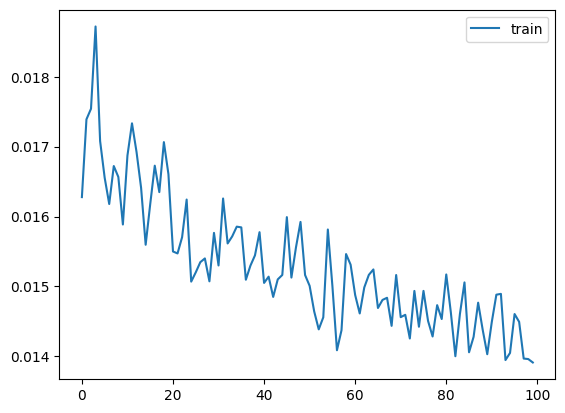

In [105]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

# Get Test Data(Unseen) by include {n_input_lookback} to predict

# Set Test data for prediction

In [67]:
# test_arr will get start with the last n look back to predict
idx_train_to_test=len(dfValues)-len(test_values)-n_input
print("The first train data to predict the frist test :",idx_train_to_test)



The first train data to predict the frist test : 183


In [68]:
test_arr=dfValues[idx_train_to_test:]
print(f"Get Test Data {len(test_values)} + {n_input} to predict = {test_arr.shape}")
print(test_arr.shape)
test_scaled_arr=scaler.fit_transform(test_arr)
print(test_scaled_arr.shape)
print(test_scaled_arr[:2])


Get Test Data 48 + 10 to predict = (58, 8)
(58, 8)
(58, 8)
[[0.15225435 0.26933102 0.40293383 0.40293383 0.0417124  0.30278232
  0.10484895 0.        ]
 [0.17747019 0.23305821 0.34675406 0.34675406 0.04884742 0.24222586
  0.14242193 0.01740139]]


In [69]:
#No.row = len(test_arr)-n_hop_lookback  , we will start triaing at the first rows since n_hop
X_test=[]
for i in range(n_input,test_scaled_arr.shape[0]):
   X_test.append(test_scaled_arr[i-n_input:i]) 
X_test=np.array(X_test)
print(X_test.shape)
print(X_test[:2])

(48, 10, 8)
[[[0.15225435 0.26933102 0.40293383 0.40293383 0.0417124  0.30278232
   0.10484895 0.        ]
  [0.17747019 0.23305821 0.34675406 0.34675406 0.04884742 0.24222586
   0.14242193 0.01740139]
  [0.12731259 0.18918332 0.28526841 0.28526841 0.04610318 0.18821604
   0.10002539 0.03103248]
  [0.04659449 0.12988705 0.2119226  0.2119226  0.02524698 0.13747954
   0.03528814 0.06670534]
  [0.         0.06798436 0.13545568 0.13545568 0.00274424 0.08837971
   0.         0.04930394]
  [0.00945594 0.01998262 0.06835206 0.06835206 0.         0.04500818
   0.01650165 0.02900232]
  [0.07605865 0.         0.0221598  0.0221598  0.03073546 0.01309329
   0.1320132  0.02668213]
  [0.21406057 0.02345786 0.01029963 0.01029963 0.11031833 0.
   0.34094948 0.08178654]
  [0.21570508 0.04300608 0.         0.         0.17837541 0.00081833
   0.34323432 0.15197216]
  [0.33561738 0.09361425 0.01654182 0.01654182 0.27716795 0.02045827
   0.50393501 0.26711137]]

 [[0.17747019 0.23305821 0.34675406 0.346754

# Prediction

In [70]:
y_test_scaled_pred=model.predict(X_test)
print("Before Invert :",y_test_scaled_pred.shape)
y_test_scaled_pred[:3]

2/2 [==============================] - 0s 0s/step
Before Invert : (48, 8)


array([[0.12469428, 0.00797354, 0.08279821, 0.0581281 , 0.24525438,
        0.18388332, 0.37245935, 0.25468513],
       [0.17043182, 0.03347797, 0.06775169, 0.05136897, 0.35597137,
        0.26473942, 0.44976336, 0.33827913],
       [0.232137  , 0.07930589, 0.05998853, 0.05943577, 0.4969562 ,
        0.37210235, 0.53994805, 0.44584692]], dtype=float32)

In [71]:
y_test_pred=scaler.inverse_transform(y_test_scaled_pred)
print("After Invert :" ,y_test_pred.shape)
y_test_pred[:3]

After Invert : (48, 8)


array([[946.319    , 947.2871   , 958.78284  , 957.99243  ,  -6.0114655,
         -5.092946 ,  45.271175 ,  40.701546 ],
       [949.65643  , 948.46136  , 958.3007   , 957.7759   ,  -3.9942017,
         -4.104884 ,  48.31618  ,  43.583866 ],
       [954.159    , 950.5712   , 958.052    , 958.0343   ,  -1.425458 ,
         -2.7929091,  51.868553 ,  47.2928   ]], dtype=float32)

# Create Predction DataFrame and Measure and Plot Chart

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        48 non-null     float64
 1   Price-Pred   48 non-null     float32
 2   EMA1         48 non-null     float64
 3   EMA1-Pred    48 non-null     float32
 4   EMA2         48 non-null     float64
 5   EMA2-Pred    48 non-null     float32
 6   EMA3         48 non-null     float64
 7   EMA3-Pred    48 non-null     float32
 8   MACD         48 non-null     float64
 9   MACD-Pred    48 non-null     float32
 10  SIGNAL       48 non-null     float64
 11  SIGNAL-Pred  48 non-null     float32
 12  RSI          48 non-null     float64
 13  RSI-Pred     48 non-null     float32
 14  RSI-MA       48 non-null     float64
 15  RSI-MA-Pred  48 non-null     float32
dtypes: float32(8), float64(8)
memory usage: 4.6 KB
None


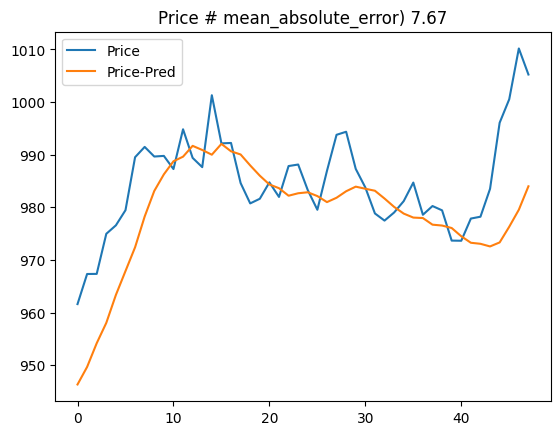

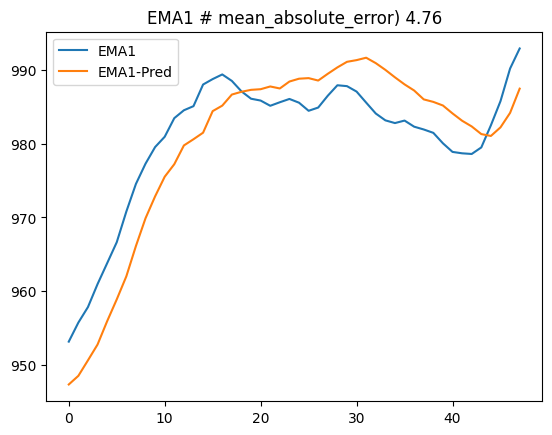

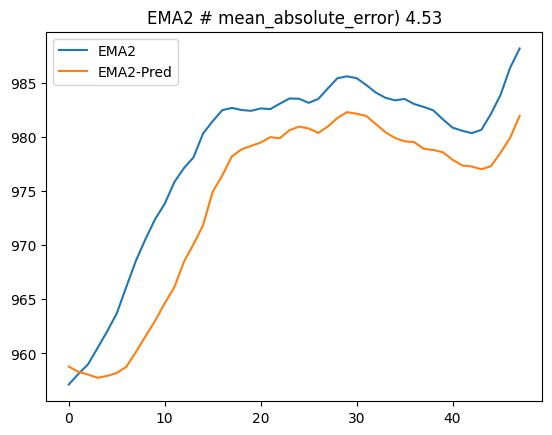

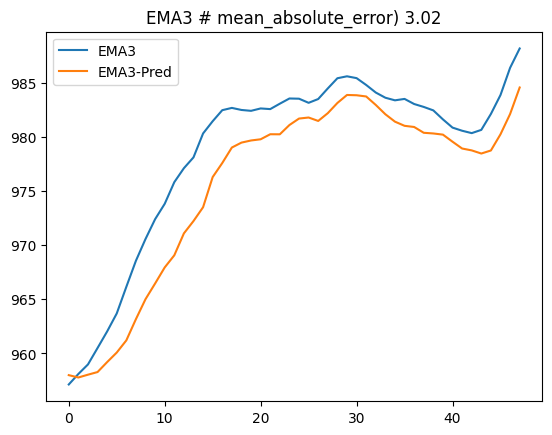

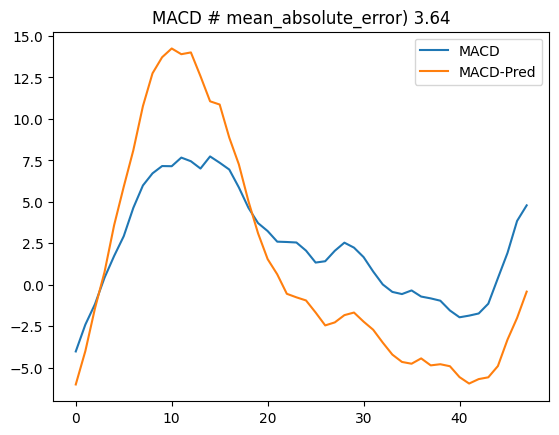

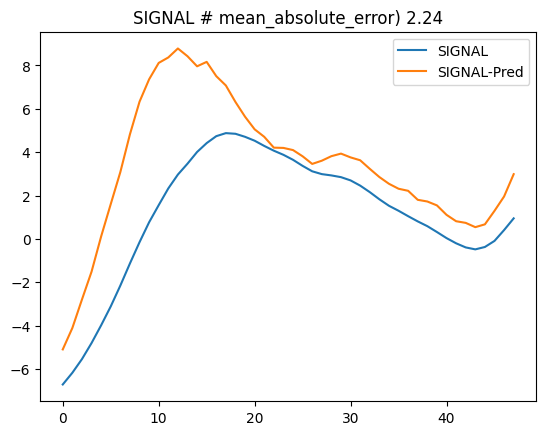

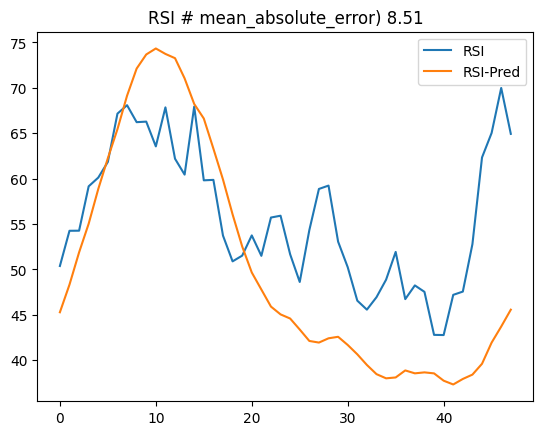

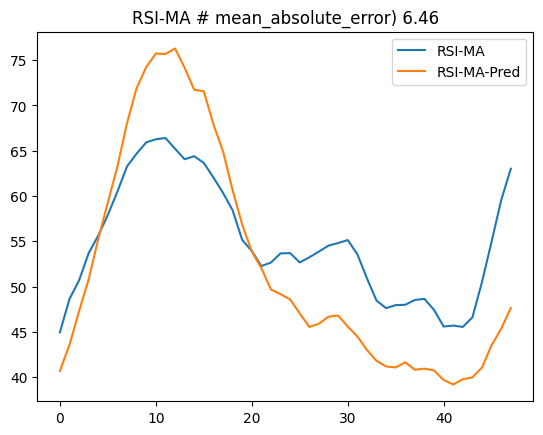

In [73]:
test_df=pd.DataFrame()
listColPair=[]
for i in range(0,len(my_features)): 
  dfActual=pd.DataFrame(data={my_features[i]:test_values[:,i]})  
  dfPred=pd.DataFrame(data={f'{my_features[i]}-Pred':y_test_pred[:,i]})
  listColPair.append([my_features[i],f'{my_features[i]}-Pred'])
  test_df=pd.concat([test_df,dfActual,dfPred],axis=1)
print(test_df.info())

#fig, axs = plt.subplots(nrows=len(listColPair), ncols=1, figsize=(14, 5*len(listColPair)))
for colPair in listColPair:
  # rmse = np.sqrt(mean_squared_error(test_df[colPair[0]], test_df[colPair[1]]))
  # title=f'{colPair[0]} # Root Mean Square Error(RMSE) {round(rmse,2)}'
  mae_x = mean_absolute_error(test_df[colPair[0]], test_df[colPair[1]])
  title=f'{colPair[0]} # {my_loss}) {round(mae_x,2)}'  
  test_df[colPair].plot(title=title)
  plt.legend()
  plt.show()

# Predict One Value

In [74]:
print(f"We will use the last {n_input} data to predict the new one")
last_train_batch=train[-n_input:]
print(last_train_batch.shape,last_train_batch)

print("We need reshape first")
last_train_batch =last_train_batch .reshape((1,n_input,n_features))
print(last_train_batch.shape,last_train_batch)

print("Predict")
last_predict=model.predict(last_train_batch)
print(last_predict)

last_predict = scaler.inverse_transform(last_predict)
print(last_predict.shape,last_predict)


We will use the last 60 data to predict the new one
(60, 8) [[0.39077227 0.37290137 0.38332009 0.38332009 0.73236426 0.76341324
  0.39903004 0.45659824]
 [0.37735634 0.36583795 0.37936811 0.37936811 0.71686618 0.75756279
  0.36710225 0.42463343]
 [0.37826847 0.36021298 0.37586718 0.37586718 0.70628474 0.75057078
  0.36993129 0.39398827]
 [0.39698617 0.35948302 0.37472884 0.37472884 0.70831552 0.74472032
  0.42758992 0.38651026]
 [0.38592657 0.35660612 0.37249511 0.37249511 0.70510902 0.73915525
  0.39795231 0.37082111]
 [0.40289602 0.35772253 0.37230181 0.37230181 0.7116289  0.73530251
  0.44914455 0.38181818]
 [0.39900046 0.35785135 0.3717219  0.3717219  0.71515605 0.73259132
  0.43782837 0.39721408]
 [0.42592733 0.36347632 0.37408449 0.37408449 0.73150919 0.73287671
  0.51488616 0.428739  ]
 [0.3979363  0.36233844 0.37320389 0.37320389 0.73011971 0.73287671
  0.43365216 0.43005865]
 [0.40025464 0.36188759 0.37266694 0.37266694 0.73054724 0.73301941
  0.44038798 0.43929619]
 [0.371370